# Bolivian  Odds Data
## 2. Feature Matrix and Visual Exploration
This notebook seeks to explore the data through visualizations using seaborn and matplot lib and also to create new features based on team performance throughout each season

In [36]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import string
import matplotlib.ticker as ticker
import re
from collections import Counter
style.use('fivethirtyeight')
palette = "ch:-.2,2.5,dark=.3_r"


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [37]:
# Reading the prepared csv file
odds = pd.read_csv('/Users/miketondu/Dropbox/Data Science/Sharpest Minds/odds_data/bolivian_football_odds_clean.csv',
                   parse_dates=['date'])
odds.sort_values(by='date', inplace=True)

odds.shape

(20777, 32)

In [4]:
odds.head()

,match,match_href,bookmakers,home_odds,draw_odds,away_odds,payout,date,time,season_year,home_team,away_team,final_result,home_goals,away_goals,first_half_home,first_half_away,second_half_home,second_half_away,total_goals,total_first_half,total_second_half,win_home_or_away,winner,home_win,away_win,home_loss,away_loss,implied_home_odds,implied_draw_odds,implied_away_odds,upset
5056,Real Potosi - Aurora,https://www.oddsportal.com/soccer/bolivia/liga...,bet-at-home,1.85,3.25,3.40,0.88,2008-10-19,17:30,2008,Real Potosi,Aurora,1:1,1,1,1,0,0,1,2,1,1,0,Draw,0,0,0,0,0.541,0.308,0.294,0
4477,Real Potosi - Aurora,https://www.oddsportal.com/soccer/bolivia/liga...,bwin,1.88,3.35,3.55,0.90,2008-10-19,17:30,2008,Real Potosi,Aurora,1:1,1,1,1,0,0,1,2,1,1,0,Draw,0,0,0,0,0.532,0.299,0.282,0
3250,La Paz - Blooming,https://www.oddsportal.com/soccer/bolivia/liga...,bet-at-home,1.65,3.50,3.95,0.87,2008-10-19,19:30,2008,La Paz,Blooming,2:1,2,1,1,0,1,1,3,1,2,1,La Paz,1,0,0,1,0.606,0.286,0.253,0
7759,La Paz - Blooming,https://www.oddsportal.com/soccer/bolivia/liga...,bwin,1.65,3.65,4.30,0.90,2008-10-19,19:30,2008,La Paz,Blooming,2:1,2,1,1,0,1,1,3,1,2,1,La Paz,1,0,0,1,0.606,0.274,0.233,0
7325,Blooming - La Paz,https://www.oddsportal.com/soccer/bolivia/liga...,bwin,1.55,3.50,5.50,0.90,2008-10-24,19:30,2008,Blooming,La Paz,5:0,5,0,2,0,3,0,5,2,3,1,Blooming,1,0,0,1,0.645,0.286,0.182,0


## Feature Engineering
Create features based on location and running averages throughout the seasons on a per team preformance basis

In [5]:
# Create an altitude feature (Based on teams playing at 3600m above sea level+)
altitude = ['Bolivar', 'The Strongest', 'Real Potosi', 'San Jose',
            'Real Potosi','Nacional Potosi', 'Always Ready', 'La Paz' ]
odds['altitude'] = ''
for i in range(len(odds)):
    if (odds['home_team'].values[i] in altitude):
        odds['altitude'].values[i] = 1
    else:
        odds['altitude'].values[i] = 0


### Matrix Function Home/Away Results

Creates a matrix for wins/losses **as home team** and wins/losses **as away team** during each season , then these four columns are wrangled in order to create running total win/loss columns for each home and away team.

In [6]:
# GOAL: make a function that will get you the number of wins for different columns (home_win, away_win,)
def matrix_func(dataframe, target_col):
    '''Creates a matrix for season home wins/losses 
    or away wins/losses depending on which of the 
    4 target_col is chosen'''
    team_1 = 'home_team' if 'home' in target_col else 'away_team'
    team_2 = 'away_team' if 'home' in target_col else 'home_team'
    # Keeping only unique matches
    df_unique = dataframe.drop_duplicates('match_href')
    # Creating reduced dataframe with TARGET_COL
    df_unique = df_unique.loc[:,[team_1,team_2,'date','season_year', target_col]]
    df_unique.sort_values(by='date',inplace=True)
    # Wide format data
    df_unique = df_unique.pivot_table(index=[team_1,'date','season_year'], 
                                  columns=team_2, 
                                  values=target_col,aggfunc=sum)
    # Creating incremental wins/losses column
    df_unique['incr'] = df_unique.apply(lambda x: x.sum(),axis=1)

    # Group_by team and season year
    df_unique = (df_unique.groupby([team_1, 'season_year'])
                 .cumsum().groupby([team_1, 'season_year'])
                 .shift(1)
                 .fillna(0))
    df_unique.rename(columns={'incr':'cumulative_'+ target_col},inplace=True)
    df_unique = df_unique.iloc[:,-1:].reset_index()

    return df_unique

# Creating the four new columns by running the matrix function
matrix_columns = ['home_win','away_win', 'home_loss', 'away_loss']
new_cols = []
for col in matrix_columns:
    new_cols.append(matrix_func(odds, col))

# Merging the four new matrix columns 
for df in new_cols:
    team_location = df.columns[0]
    odds = odds.merge(df, on=[team_location, 'date','season_year'], how='left')




#### Creating combined columns for running wins & losses 
The product of this data transformation are running totals for both wins and losses for each home and away team during each season.

##### Win Columns:

In [7]:
######## WINS ########
# Creating two dataframes (home/away)

game_home = (odds.drop_duplicates('match_href')
             .loc[:,['home_team', 'date', 'season_year', 'cumulative_home_win']]
             .sort_values(by=['home_team', 'date']))
game_away = (odds.drop_duplicates('match_href')
             .loc[:,['away_team', 'date', 'season_year', 'cumulative_away_win']]
             .sort_values(by=['away_team', 'date']))

# renaming home_team and away_team to 'team'
game_home.rename(columns={'home_team':'team'},inplace=True)
game_away.rename(columns={'away_team':'team'},inplace=True)

# Concatenating the two datagrames 
game_of_season = (pd.concat([game_home,game_away]))
game_of_season['team_temp'] = game_of_season['team'] #temporary team variable copied for merging purposes
game_of_season = (game_of_season
                  .sort_values(by=['team_temp','season_year','date'])
                  .reset_index(drop=True)
                  .groupby(['team_temp', 'season_year'])
                  .fillna(method='ffill')
                  .fillna(0)
                  )
                 
# Create the single column 
game_of_season['season_wins'] = (game_of_season['cumulative_home_win'] + game_of_season['cumulative_away_win'])
game_of_season = game_of_season.loc[:,['team','date', 'season_wins']]


# Merging the win columns for home team
odds = (odds.merge(game_of_season, left_on=['home_team','date'],
          right_on=['team','date'], how='left')
        .rename(columns={'season_wins':'season_wins_home_team'})
       )
# Merging the win columns for away team
odds =  (odds.merge(game_of_season, left_on=['away_team','date'],
          right_on=['team','date'], how='left')
         .rename(columns={'season_wins':'season_wins_away_team'})
        )

odds.drop(['team_x', 'team_y'],axis=1,inplace=True)


/Users/miketondu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


#### Loss columns:

In [8]:
######## LOSSES ########

# Creating two dataframes (home/away)

game_home = (odds.drop_duplicates('match_href')
             .loc[:,['home_team', 'date', 'season_year', 'cumulative_home_loss']]
             .sort_values(by=['home_team', 'date']))
game_away = (odds.drop_duplicates('match_href')
             .loc[:,['away_team', 'date', 'season_year', 'cumulative_away_loss']]
             .sort_values(by=['away_team', 'date']))

# renaming home_team and away_team to 'team'
game_home.rename(columns={'home_team':'team'},inplace=True)
game_away.rename(columns={'away_team':'team'},inplace=True)

# Concatenating the two datagrames 
game_of_season = (pd.concat([game_home,game_away]))
game_of_season['team_temp'] = game_of_season['team'] #temporary team variable copied for merging purposes
game_of_season = (game_of_season
                  .sort_values(by=['team_temp','season_year','date'])
                  .reset_index(drop=True)
                  .groupby(['team_temp', 'season_year'])
                  .fillna(method='ffill')
                  .fillna(0)
                  )
                 

# Create the single column 
game_of_season['season_losses'] = (game_of_season['cumulative_home_loss'] + game_of_season['cumulative_away_loss'])
game_of_season = game_of_season.loc[:,['team', 'date', 'season_losses']]



# Merging the LOSS columns for home team
odds = (odds.merge(game_of_season, left_on=['home_team','date'],
          right_on=['team','date'], how='left')
        .rename(columns={'season_losses':'season_losses_home_team'})
       )
# Merging the LOSS columns for away team
odds =  (odds.merge(game_of_season, left_on=['away_team','date'],
          right_on=['team','date'], how='left')
         .rename(columns={'season_losses':'season_losses_away_team'})
        )

odds.drop(['team_x', 'team_y'],axis=1,inplace=True)


/Users/miketondu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



### Game of season variable
Creating a running game_of_season variable for each home and away team

In [9]:
# Create a a "game_of_season" variable for each team

# Game of season variable (home team)
game_home = (odds.drop_duplicates('match_href').groupby(['season_year','date','home_team',])
        .size()
        .groupby(['home_team','season_year'])
        .cumsum()
        .reset_index().rename(columns={0:'game_of_season_as_home_team'}))
#odds = odds.merge(game_home, right_on=['season_year','date','home_team'], left_on=['season_year','date','home_team'])

# Game of season variable (away team)
game_away = (odds.drop_duplicates('match_href').groupby(['season_year','date','away_team',])
        .size()
        .groupby(['away_team','season_year'])
        .cumsum()
        .reset_index().rename(columns={0:'game_of_season_as_away_team'}))
#odds = odds.merge(game_away, right_on=['season_year','date','away_team'], left_on=['season_year','date','away_team'])


################################################################################################################
# Game of season variable for both HOME and AWAY teams    
game_home.rename(columns={'home_team':'team'},inplace=True)
game_away.rename(columns={'away_team':'team'},inplace=True)

# Concatenating the two datagrames 
game_of_season = (pd.concat([game_home,game_away]))
game_of_season['team_temp'] = game_of_season['team'] #temporary team variable copied for merging purposes
game_of_season = (game_of_season
                  .sort_values(by=['team_temp','season_year','date'])
                  .reset_index(drop=True)
                  .groupby(['team_temp', 'season_year'])
                  .fillna(method='ffill')
                  .fillna(0)
                  )
                 
# Create the single column 
game_of_season['game_of_season'] = (game_of_season['game_of_season_as_away_team'] +
                                    game_of_season['game_of_season_as_home_team'])


game_of_season=game_of_season.loc[:,['date', 'team','game_of_season']]

# Merging game_of_season for home team
odds = (odds.merge(game_of_season, 
                   left_on=['home_team','date'],
                   right_on=['team','date'], 
                   how='left')
        .rename(columns={'game_of_season':'game_of_season_home_team'})
       )

# Merging game_of_season for away team
odds = (odds.merge(game_of_season, 
                   left_on=['away_team','date'], 
                   right_on=['team','date'],
                   how='left')
        .rename(columns={'game_of_season':'game_of_season_away_team'})
       )

odds.drop(['team_x', 'team_y'],axis=1,inplace=True)

/Users/miketondu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [10]:
odds.head()

,match,match_href,bookmakers,home_odds,draw_odds,away_odds,payout,date,time,season_year,home_team,away_team,final_result,home_goals,away_goals,first_half_home,first_half_away,second_half_home,second_half_away,total_goals,total_first_half,total_second_half,win_home_or_away,winner,home_win,away_win,home_loss,away_loss,implied_home_odds,implied_draw_odds,implied_away_odds,upset,altitude,cumulative_home_win,cumulative_away_win,cumulative_home_loss,cumulative_away_loss,season_wins_home_team,season_wins_away_team,season_losses_home_team,season_losses_away_team,game_of_season_home_team,game_of_season_away_team
0,Real Potosi - Aurora,https://www.oddsportal.com/soccer/bolivia/liga...,bet-at-home,1.85,3.25,3.40,0.88,2008-10-19,17:30,2008,Real Potosi,Aurora,1:1,1,1,1,0,0,1,2,1,1,0,Draw,0,0,0,0,0.541,0.308,0.294,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,Real Potosi - Aurora,https://www.oddsportal.com/soccer/bolivia/liga...,bwin,1.88,3.35,3.55,0.90,2008-10-19,17:30,2008,Real Potosi,Aurora,1:1,1,1,1,0,0,1,2,1,1,0,Draw,0,0,0,0,0.532,0.299,0.282,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,La Paz - Blooming,https://www.oddsportal.com/soccer/bolivia/liga...,bet-at-home,1.65,3.50,3.95,0.87,2008-10-19,19:30,2008,La Paz,Blooming,2:1,2,1,1,0,1,1,3,1,2,1,La Paz,1,0,0,1,0.606,0.286,0.253,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,La Paz - Blooming,https://www.oddsportal.com/soccer/bolivia/liga...,bwin,1.65,3.65,4.30,0.90,2008-10-19,19:30,2008,La Paz,Blooming,2:1,2,1,1,0,1,1,3,1,2,1,La Paz,1,0,0,1,0.606,0.274,0.233,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,Blooming - La Paz,https://www.oddsportal.com/soccer/bolivia/liga...,bwin,1.55,3.50,5.50,0.90,2008-10-24,19:30,2008,Blooming,La Paz,5:0,5,0,2,0,3,0,5,2,3,1,Blooming,1,0,0,1,0.645,0.286,0.182,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0


## Visualization and Exploration

The purpose of this section is to visually explore the data in order to find interesting trends and patterns that could become relevant features in the modelling phase.

In [11]:
#odds.drop(['final_result'], axis=1, inplace=True)
#odds.head()



### Teams
This section will focus on individual teams and their overall performance

In [12]:
odds_unique_matches = odds.drop_duplicates('match_href')
odds_unique_matches.columns
odds_unique_matches.shape

Index(['match', 'match_href', 'bookmakers', 'home_odds', 'draw_odds',
       'away_odds', 'payout', 'date', 'time', 'season_year', 'home_team',
       'away_team', 'final_result', 'home_goals', 'away_goals',
       'first_half_home', 'first_half_away', 'second_half_home',
       'second_half_away', 'total_goals', 'total_first_half',
       'total_second_half', 'win_home_or_away', 'winner', 'home_win',
       'away_win', 'home_loss', 'away_loss', 'implied_home_odds',
       'implied_draw_odds', 'implied_away_odds', 'upset', 'altitude',
       'cumulative_home_win', 'cumulative_away_win', 'cumulative_home_loss',
       'cumulative_away_loss', 'season_wins_home_team',
       'season_wins_away_team', 'season_losses_home_team',
       'season_losses_away_team', 'game_of_season_home_team',
       'game_of_season_away_team'],
      dtype='object')

(2843, 43)

#### Altitude Advantage

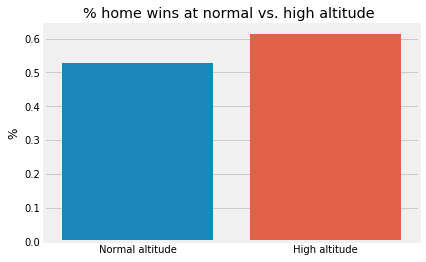

In [13]:
# Percentage home wins in high altitude games for all teams
data = odds_unique_matches.groupby('altitude')['home_win'].apply(lambda x: sum(x)/len(x))
data
fig, axes= plt.subplots(figsize=(6,4))
sns.barplot(data.index, data)

plt.title('% home wins at normal vs. high altitude ')
axes.set_xticklabels(['Normal altitude', 'High altitude'])
axes.set_xlabel('')
axes.set_ylabel('%');



Teams playing as home team in high altitude locations, tend to win 10% more often.

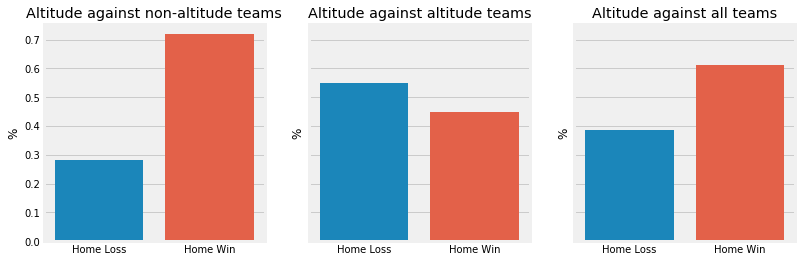

In [41]:
# Percentage wins for home team in altitude playing against low altitude teams 
altitude = ['Bolivar', 'The Strongest', 'Real Potosi', 'San Jose',
            'Real Potosi','Nacional Potosi', 'Always Ready', 'La Paz' ]

# Creating figure for plots
fig, axes= plt.subplots(1,3,figsize=(12,4),sharey=True)

# Subsetting low altitude away teams vs altitude home teams
data = odds_unique_matches.loc[(odds_unique_matches['altitude'] == 1) 
                               & (~odds_unique_matches['away_team'].isin(altitude))]
data = data.home_win.value_counts(normalize=True)
data
# Graph 1
sns.barplot(data.index, data, ax=axes[0])

axes[0].set_title('Altitude against non-altitude teams')
axes[0].set_xticklabels(['Home Loss', 'Home Win'])
axes[0].set_xlabel('')
axes[0].set_ylabel('%')

# Percentage wins for home team in altitude playing against other high altitude teams 
# Subsetting low altitude away teams vs altitude home teams
data = odds_unique_matches.loc[(odds_unique_matches['altitude'] == 1) 
                               & (odds_unique_matches['away_team'].isin(altitude))]
data = data.home_win.value_counts(normalize=True)
data
# Graph 2
sns.barplot(data.index, data, ax=axes[1])
axes[1].set_title('Altitude against altitude teams')
axes[1].set_xticklabels(['Home Loss', 'Home Win'])
axes[1].set_xlabel('')
axes[1].set_ylabel('%')

# Percentage wins for home team in altitude playing against all teams 
# Subsetting low altitude away teams vs altitude home teams

data = odds_unique_matches.loc[(odds_unique_matches['altitude'] == 1)]
data = data.home_win.value_counts(normalize=True)
data
# Graph 2
sns.barplot(data.index, data, ax = axes[2])
axes[2].set_title('Altitude against all teams')
axes[2].set_xticklabels(['Home Loss', 'Home Win'])
axes[2].set_xlabel('')
axes[2].set_ylabel('%');


- High altitude teams playing at home against low altitude teams win about 72% of the time
- High altitude teams playing at home against other high altitude teams win only 45% of the time (interesting)
- High altitude teams playing at home win  61% of the time on average



#### Win Rate

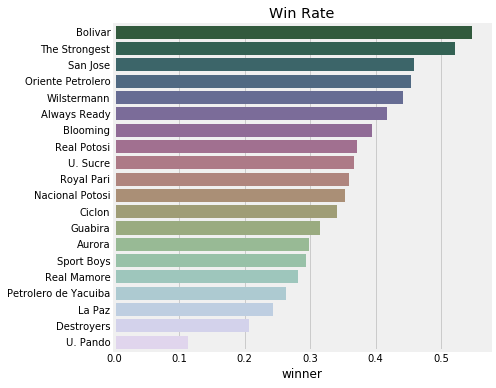

In [53]:
# Highest win percentage

# Number of games won per team
data = odds_unique_matches.winner.value_counts()
data.index.unique()
data.values

# Number of games played per team
games_played=[]
for i in data.index:
    games_played.append(len((odds_unique_matches.loc[(odds_unique_matches['home_team']==i) 
                                                     | (odds_unique_matches['away_team']==i) ])))
    
# Win rate
data = data/games_played
data= data[1:].sort_values(ascending=False)

# Graph
fig, axes= plt.subplots(figsize=(6,6))
sns.barplot(y=data.index, x=data, palette=palette)
axes.set_title('Win Rate');



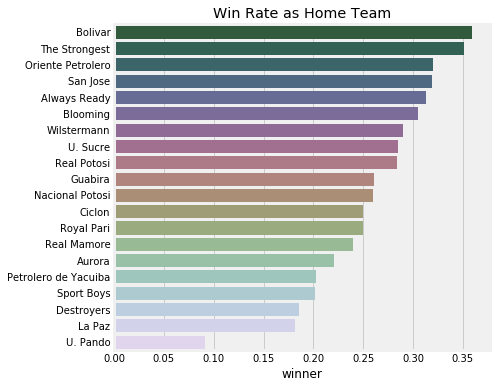

In [54]:
# Highest win percentage as home team
data = (odds_unique_matches['winner']
        .loc[odds_unique_matches['win_home_or_away']==1]
        .value_counts())

# Number of games played per team
games_played=[]
for i in data.index:
    games_played.append(len((odds_unique_matches.loc[(odds_unique_matches['home_team']==i) 
                                                     | (odds_unique_matches['away_team']==i) ])))
    
# Win rate as away team
data = data/games_played
data= data.sort_values(ascending=False)

# Graph
fig, axes= plt.subplots(figsize=(6,6))
sns.barplot(y=data.index, x=data, palette=palette)
axes.set_title('Win Rate as Home Team');

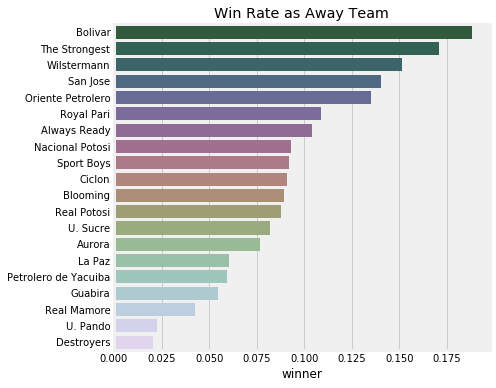

In [51]:
# Highest win percentage as away team
data = (odds_unique_matches['winner']
        .loc[odds_unique_matches['win_home_or_away']==2]
        .value_counts())

# Number of games played per team
games_played=[]
for i in data.index:
    games_played.append(len((odds_unique_matches.loc[(odds_unique_matches['home_team']==i) 
                                                     | (odds_unique_matches['away_team']==i) ])))
    
# Win rate as away team
data = data/games_played
data= data.sort_values(ascending=False)

# Graph
fig, axes= plt.subplots(figsize=(6,6))
sns.barplot(y=data.index, x=data, palette=palette)
axes.set_title('Win Rate as Away Team');

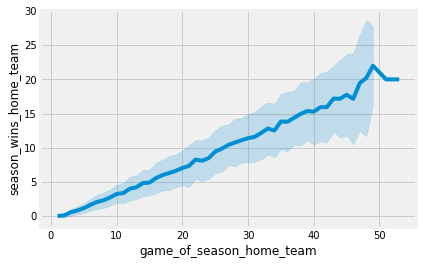

In [16]:
sns.lineplot(data=odds_unique_matches, x='game_of_season_home_team', y ='season_wins_home_team', ci='sd')


/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


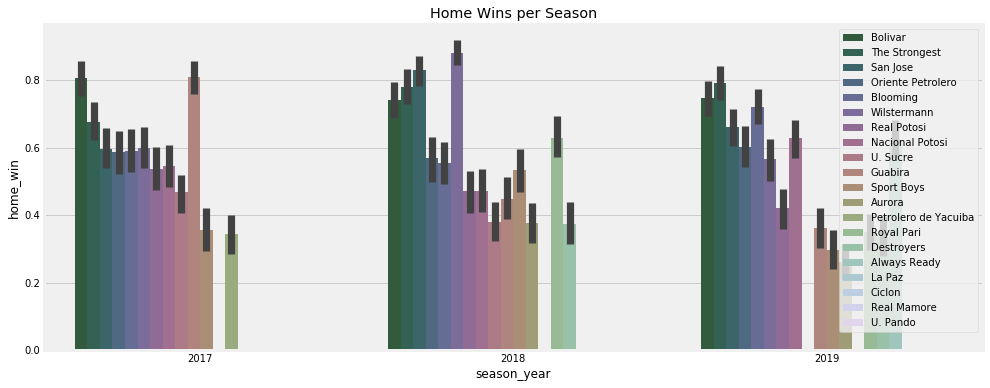

In [56]:
# Home Wins per Season
fig,axes = plt.subplots(figsize=(15,6))
sns.barplot(data=odds[(odds['date']>'2017')],
             x = 'season_year', y='home_win',hue='home_team',
            hue_order = odds.groupby('home_team')['home_win'].sum().sort_values(ascending=False).index,
           palette=palette)


plt.legend(loc='upper right')
plt.xticks(rotation=0)
plt.title('Home Wins per Season')
plt.show();

In [18]:
# Goal distributions for all teams in all matches
fig, axes = plt.subplots(figsize=(8,6))
sns.distplot(odds['total_goals'])
odds.total_goals.value_counts()

# Goal distributions for all teams in all matches
fig, axes = plt.subplots(figsize=(8,6))
sns.distplot(data = odds_unique_matches, odds_unique_matches['total_goals'])
odds.total_goals.value_counts()

SyntaxError: positional argument follows keyword argument (<ipython-input-18-4f40f6cde0d3>, line 8)

In [ ]:
# goals distribution per team boxplot 
fig, axes = plt.subplots(1,2,figsize=(18,10))
sns.boxplot(data=odds ,
            y='home_team', x='home_goals', ax=axes[0], 
            order=odds.groupby('home_team')['home_goals'].mean().sort_values(ascending=False).index)

sns.boxplot(data=odds ,
            y='away_team', x='away_goals',ax=axes[1],
           order=odds.groupby('away_team')['away_goals'].mean().sort_values(ascending=False).index)

plt.title('Goal Distribution')
plt.xticks(rotation=0)
axes[0].set_ylabel('')
axes[1].set_ylabel('')


axes[0].set_title('Goal Distribution Home')
axes[1].set_title('Goal Distribution Away')
plt.xticks(rotation=0)



In [ ]:
odds.groupby('home_team')['home_goals'].mean().sort_values(ascending=False).index

ValueError: Could not interpret input 'game_of_season_as_home_team'

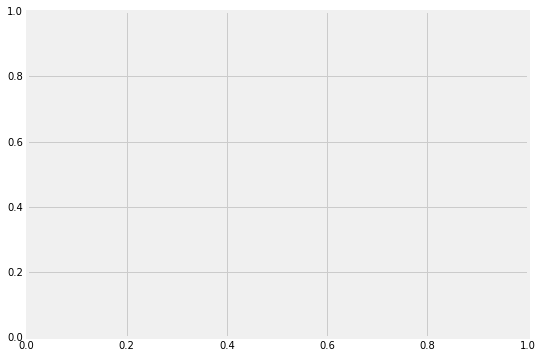

In [19]:
# game of season (home) vs. goals scored

for team in odds.home_team.unique():
    fig, axes = plt.subplots(figsize=(8,6))
    sns.lineplot(data=odds.loc[odds['home_team'] == team], x='game_of_season_as_home_team', y='home_goals')
    plt.title(team)

ValueError: Could not interpret input 'game_of_season_as_away_team'

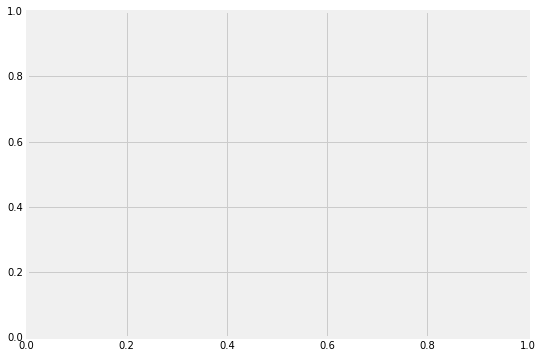

In [33]:
# game of season (away) vs. goals scored

for team in odds.home_team.unique():
    fig, axes = plt.subplots(figsize=(8,6))
    sns.lineplot(data=odds.loc[odds['away_team'] == team], x='game_of_season_as_away_team', y='away_goals')
    plt.title(team)
    plt.show()

ValueError: Could not interpret input 'game_of_season_as_away_team'

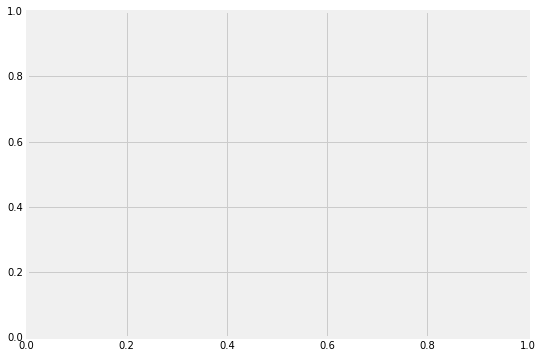

In [21]:
# game of season (away) vs. goals scored

for team in odds.home_team.unique():
    fig, axes = plt.subplots(figsize=(8,6))
    sns.lineplot(data=odds.loc[odds['away_team'] == team], x='game_of_season_as_away_team', y='away_win',)
    plt.title(team)

### Bookmakers
This section wil focus on graphing the bookmaker odds in order to find interesting trends and patterns in how the casinos set the money lines for individual matches

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


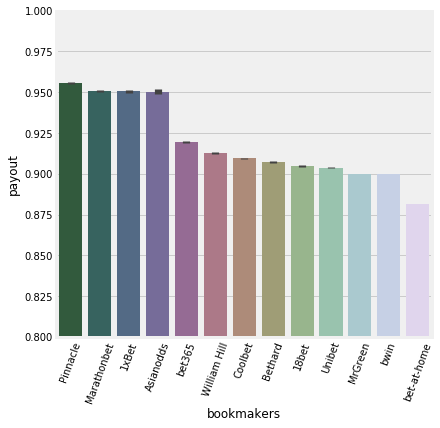

In [28]:
# Bookie average payout
fig, axes = plt.subplots(figsize=(6,6))


sns.barplot(data=odds, x='bookmakers', y='payout',
            order=odds.groupby('bookmakers')['payout'].mean().sort_values(ascending=False).index,
            palette=palette
           )

axes.set_ylim((.8,1))
plt.xticks(rotation=70);

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


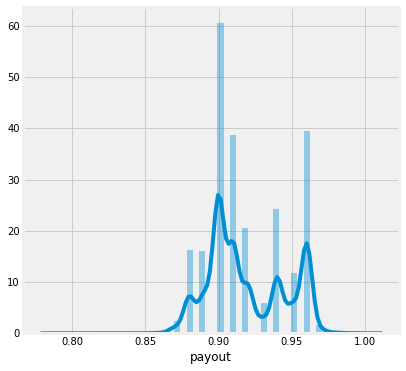

In [40]:
# Distplot of payout
fig, axes = plt.subplots(figsize=(6,6))
sns.distplot(odds['payout']);

In [57]:
odds.columns

Index(['match', 'match_href', 'bookmakers', 'home_odds', 'draw_odds',
       'away_odds', 'payout', 'date', 'time', 'season_year', 'home_team',
       'away_team', 'final_result', 'home_goals', 'away_goals',
       'first_half_home', 'first_half_away', 'second_half_home',
       'second_half_away', 'total_goals', 'total_first_half',
       'total_second_half', 'win_home_or_away', 'winner', 'home_win',
       'away_win', 'home_loss', 'away_loss', 'implied_home_odds',
       'implied_draw_odds', 'implied_away_odds', 'upset'],
      dtype='object')

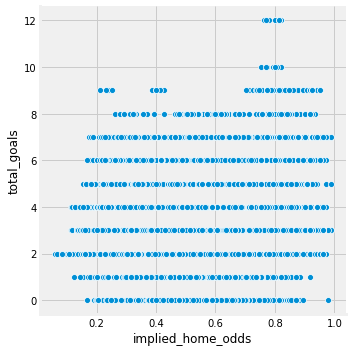

In [58]:
sns.relplot(data=odds, x='implied_home_odds', y='total_goals')

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


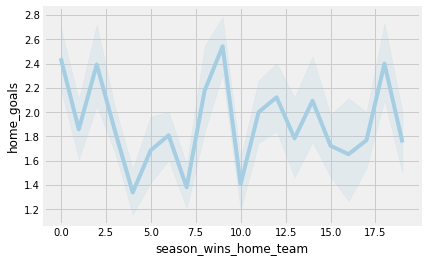

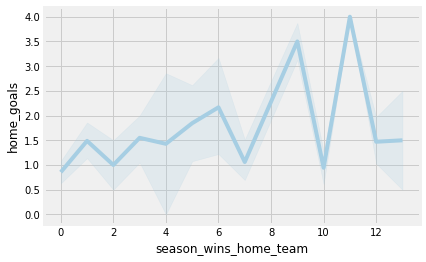

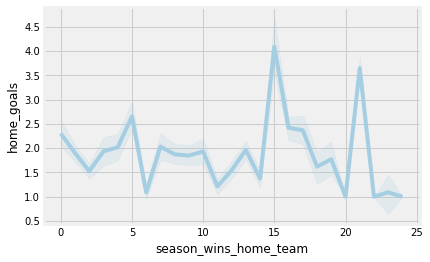

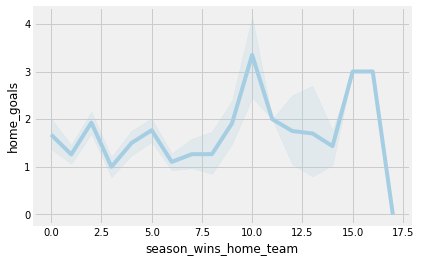

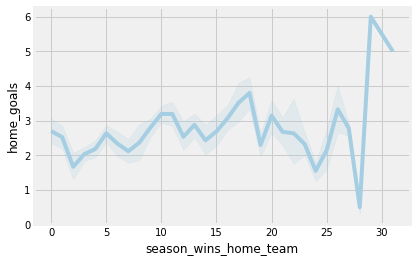

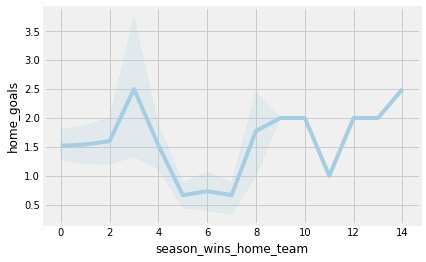

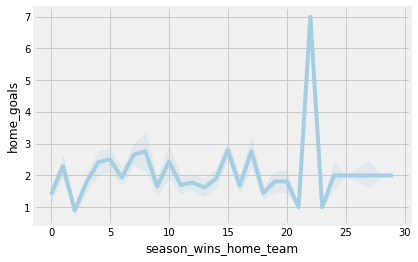

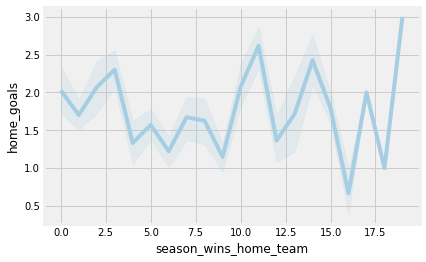

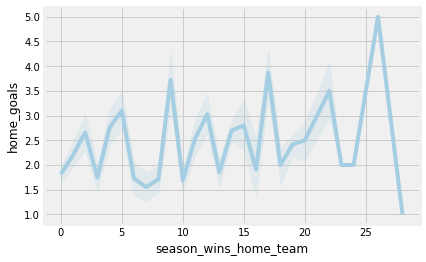

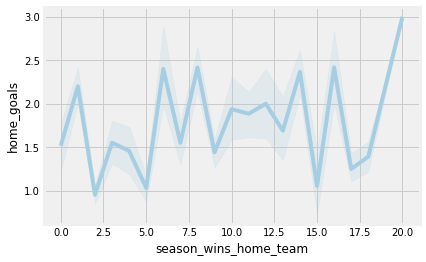

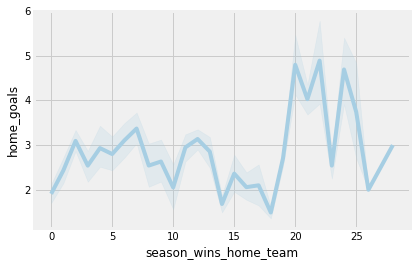

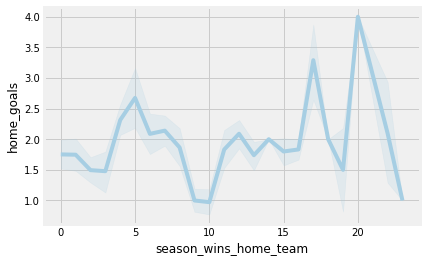

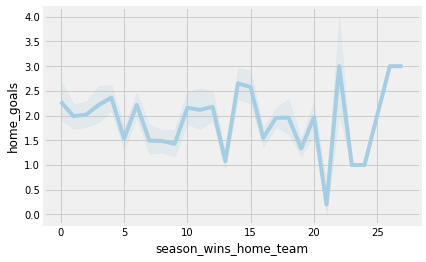

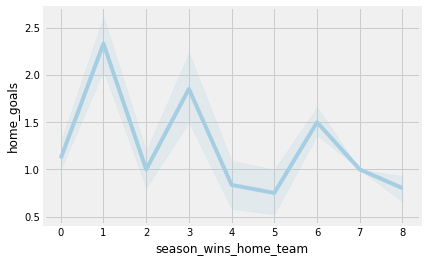

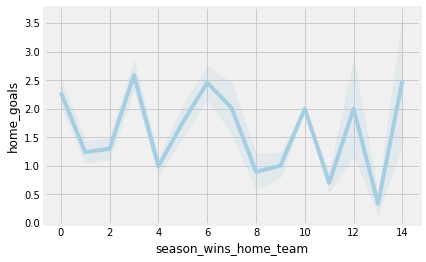

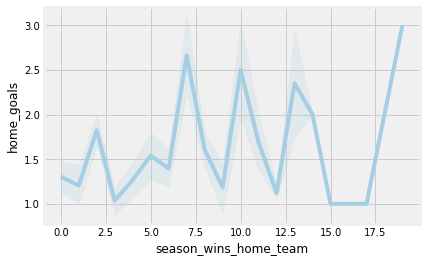

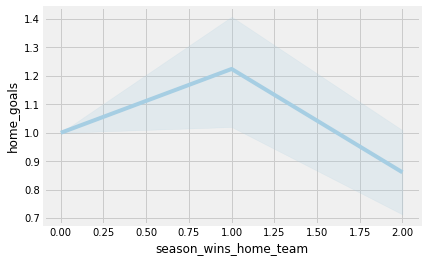

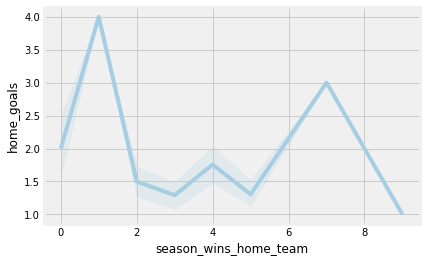

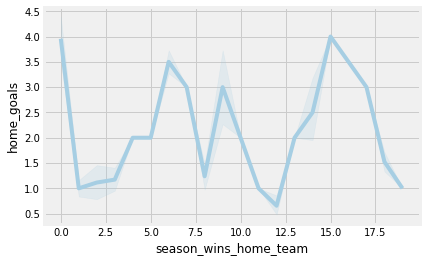

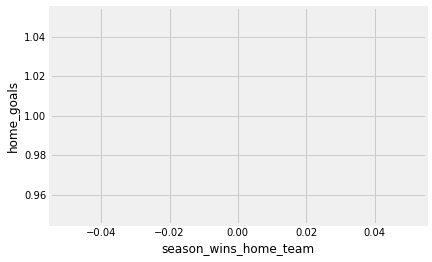

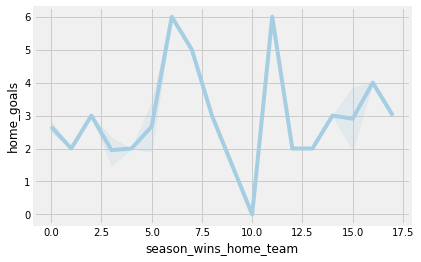

In [31]:
# wins vs. goals
for team in odds.home_team.unique():
    fig, axes = plt.subplots(figsize=(6,4))
    sns.set_palette("Paired")
    sns.lineplot(data=odds.loc[odds['home_team'] ==team] , x='season_wins_home_team', y='home_goals')
    plt.show();

Text(0.5,1,'Always Ready')

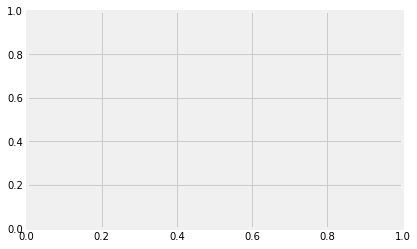

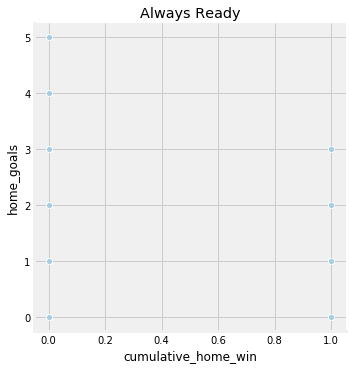

Text(0.5,1,'Always Ready')

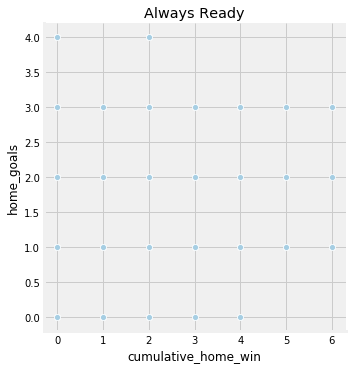

Text(0.5,1,'Always Ready')

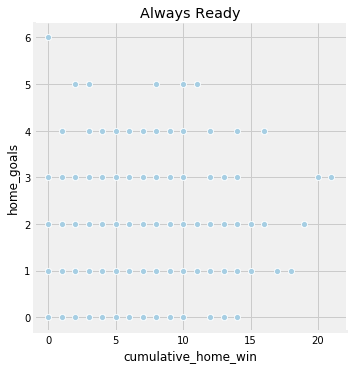

Text(0.5,1,'Always Ready')

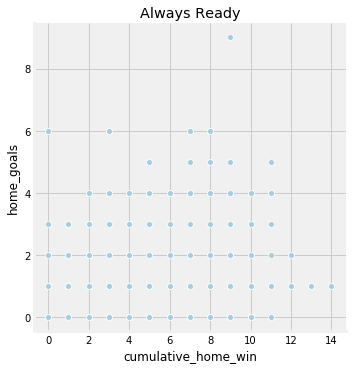

Text(0.5,1,'Always Ready')

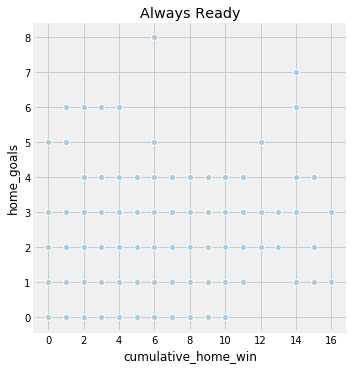

Text(0.5,1,'Always Ready')

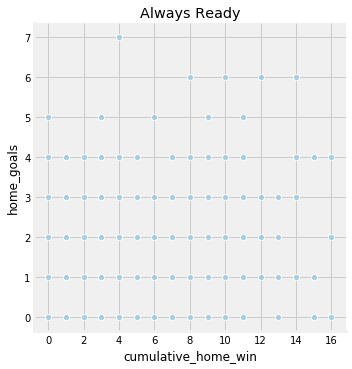

Text(0.5,1,'Always Ready')

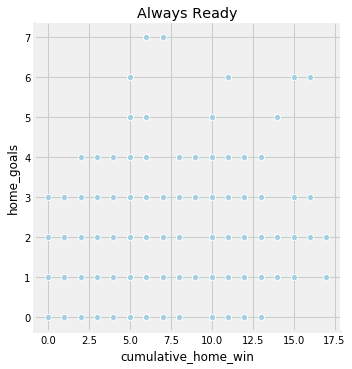

Text(0.5,1,'Always Ready')

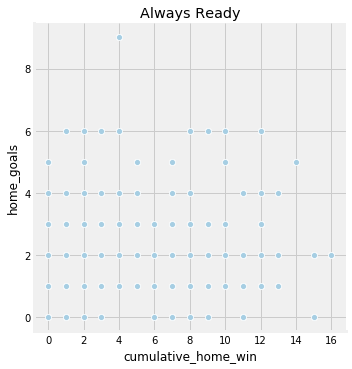

Text(0.5,1,'Always Ready')

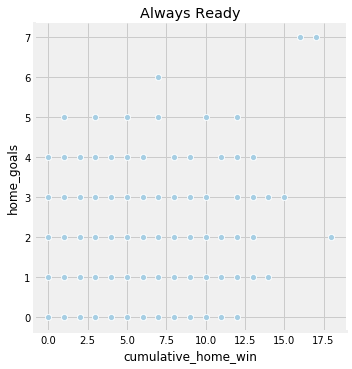

Text(0.5,1,'Always Ready')

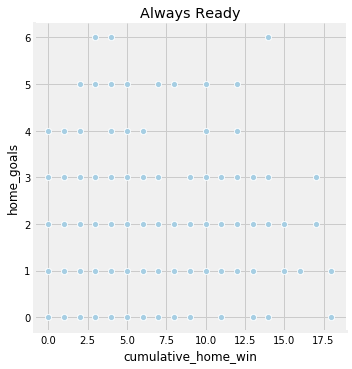

Text(0.5,1,'Always Ready')

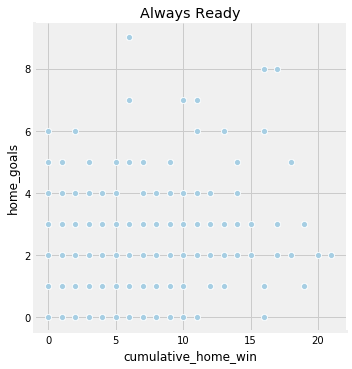

Text(0.5,1,'Always Ready')

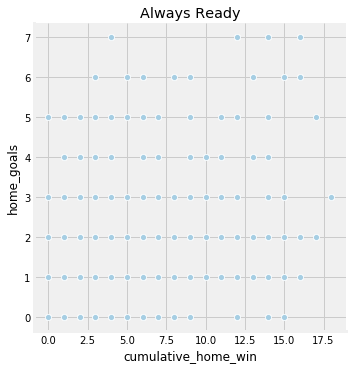

In [32]:
fig, axes = plt.subplots(figsize=(6,4))
sns.set_palette("Paired")
for year in odds.season_year.unique():
    sns.relplot(data=odds.loc[odds['season_year'] ==year] , x='cumulative_home_win', y='home_goals')
    plt.title(team)
    plt.show();

In [ ]:
odds.head()

In [215]:
odds.to_csv('/Users/miketondu/Dropbox/Data Science/Sharpest Minds/odds_data/bolivian_football_odds_prepared.csv', index=False)

In [ ]:
odds.head()